# Exploring New Alloy Systems with Pymatgen!

draft version: July 20, 2020

comments --> make more of a narrative

### The goal of this tutorial is to learn how to make a new alloy material with pymatgen, using an existing material as an end-point or starting-point. This is one of many strategies that is enabled by pymatgen for discovery of new materials. We will then compare properties of this alloy to the end point system.

Lesson contents:
1. select a test-case system (e.g. ZnS)
2. select a possible dopant (e.g. Cu)
3. create a new ternary alloy
    a. substitute dopant
    b. transform to make a new alloy
4. create a new ternary from structure prediction
5. calculate new properties

My questions:
- should I include surface stuff in analysis?
- should I include local coordination info in analysis?
- should I do structure prediction, as well as alloy transformation

### basic packages you will need

In [1]:
from pymatgen import MPRester
import pandas as pd
import numpy as np

### initiate the API with your API key

###### Now we can initiate the MP Rester API by creating an object mpr:

In [2]:
mpr = MPRester("4dM3PFrLKxptsm6A") # YOUR API KEY GOES IN THIS FUNCTION! as a string.

# 
# 1. select a test-case system

### In this notebook we will focus on cubic zinc-blende ZnS, a wide band gap (transparent) semiconductor. In my PhD research I study p-type transparent semiconductors, so I will pose the question: how can we use ZnS as a starting point to create a p-type transparent semiconductor?

###### Materials Project ID (mpid) of zinc-blende ZnS: https://materialsproject.org/materials/mp-10695/

In [3]:
ZnS_mpid = "mp-10695"

###
### get the structure

In [4]:
ZnS_structure = mpr.get_structure_by_material_id("mp-10695")

###### 
###### Check it out on our web app here: http://app.crystaltoolkit.org/mp-10695

- Click "Draw atoms outside unit cell bonded to atoms within unit cell"
- Play around with it!

### add oxidation state to structure

###### pymatgen has a simple transformation to guess the oxidation state of each specie in stoichiometric compounds. This information is needed to compare ionic radii and assess substitutional dopact probability. You can also enter the oxidation states manually if you'd prefer.

In [5]:
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation

In [6]:
oxi_transformation = AutoOxiStateDecorationTransformation()

In [7]:
ZnS_structure = oxi_transformation.apply_transformation(ZnS_structure)

In [8]:
ZnS_structure.get_space_group_info()

('F-43m', 216)

### explore the local environment!

In [9]:
# should I add this here? I think it could be useful to discuss how to calculate coordination, 
# if it's not done elsewhere, and I can tie it into dopant selection below?

In [10]:
from pymatgen.analysis.local_env import CrystalNN

### 
### plot some properties

In [11]:
from pymatgen.electronic_structure.plotter import BSPlotter

In [12]:
ZnS_bs = mpr.get_bandstructure_by_material_id(ZnS_mpid)

######
###### Initialize the band structure plotter

In [13]:
ZnS_bsp = BSPlotter(ZnS_bs)

######
###### get plot

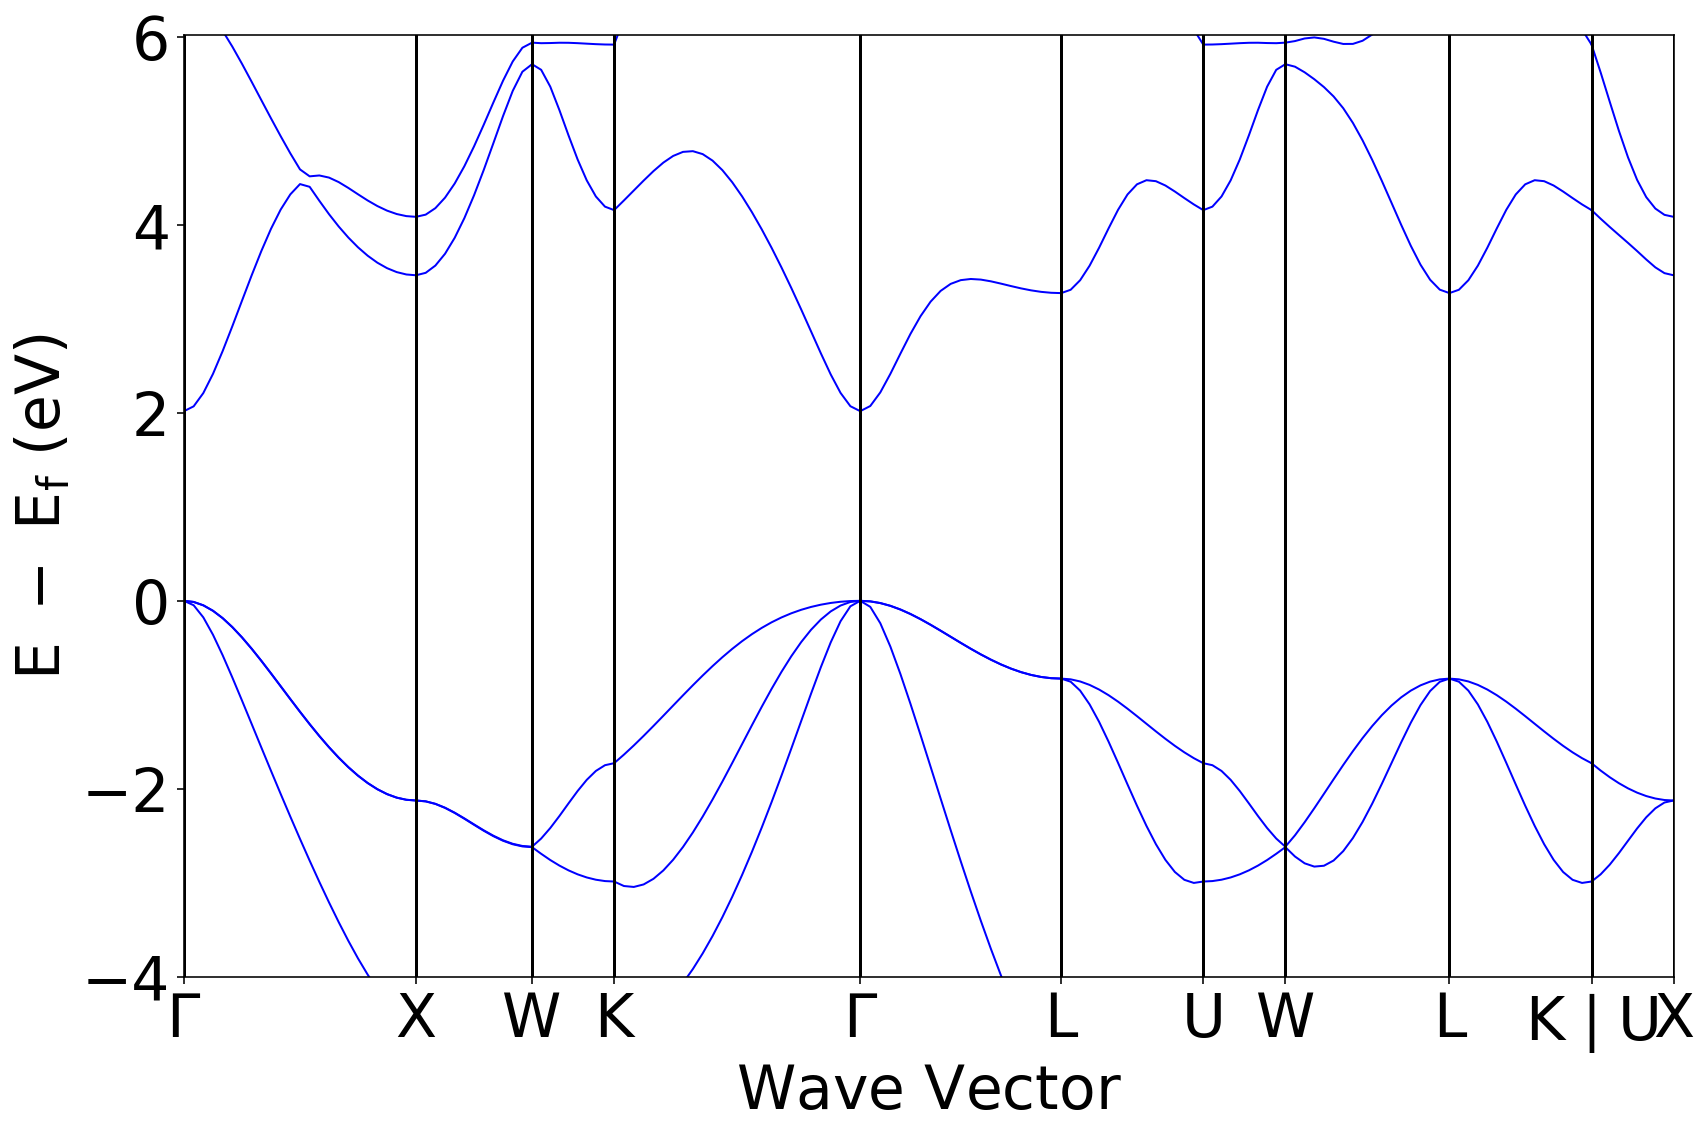

In [14]:
ZnS_bsp.show() # takes a second

### 
### Band gap correction

In [43]:
ZnS_bs.get_band_gap()

{'direct': True, 'energy': 2.0186, 'transition': '\\Gamma-\\Gamma'}

###### 
###### ZnS has an experimental gap of approximately 3.5 eV
###### But the GGA calculated gap is far too low!
###### We can apply a "scissor" to this band structure to correct for this

In [44]:
ZnS_bs_scissor = ZnS_bs.apply_scissor(new_band_gap=3.5)

In [45]:
ZnS_bsp_scissor = BSPlotter(ZnS_bs_scissor)

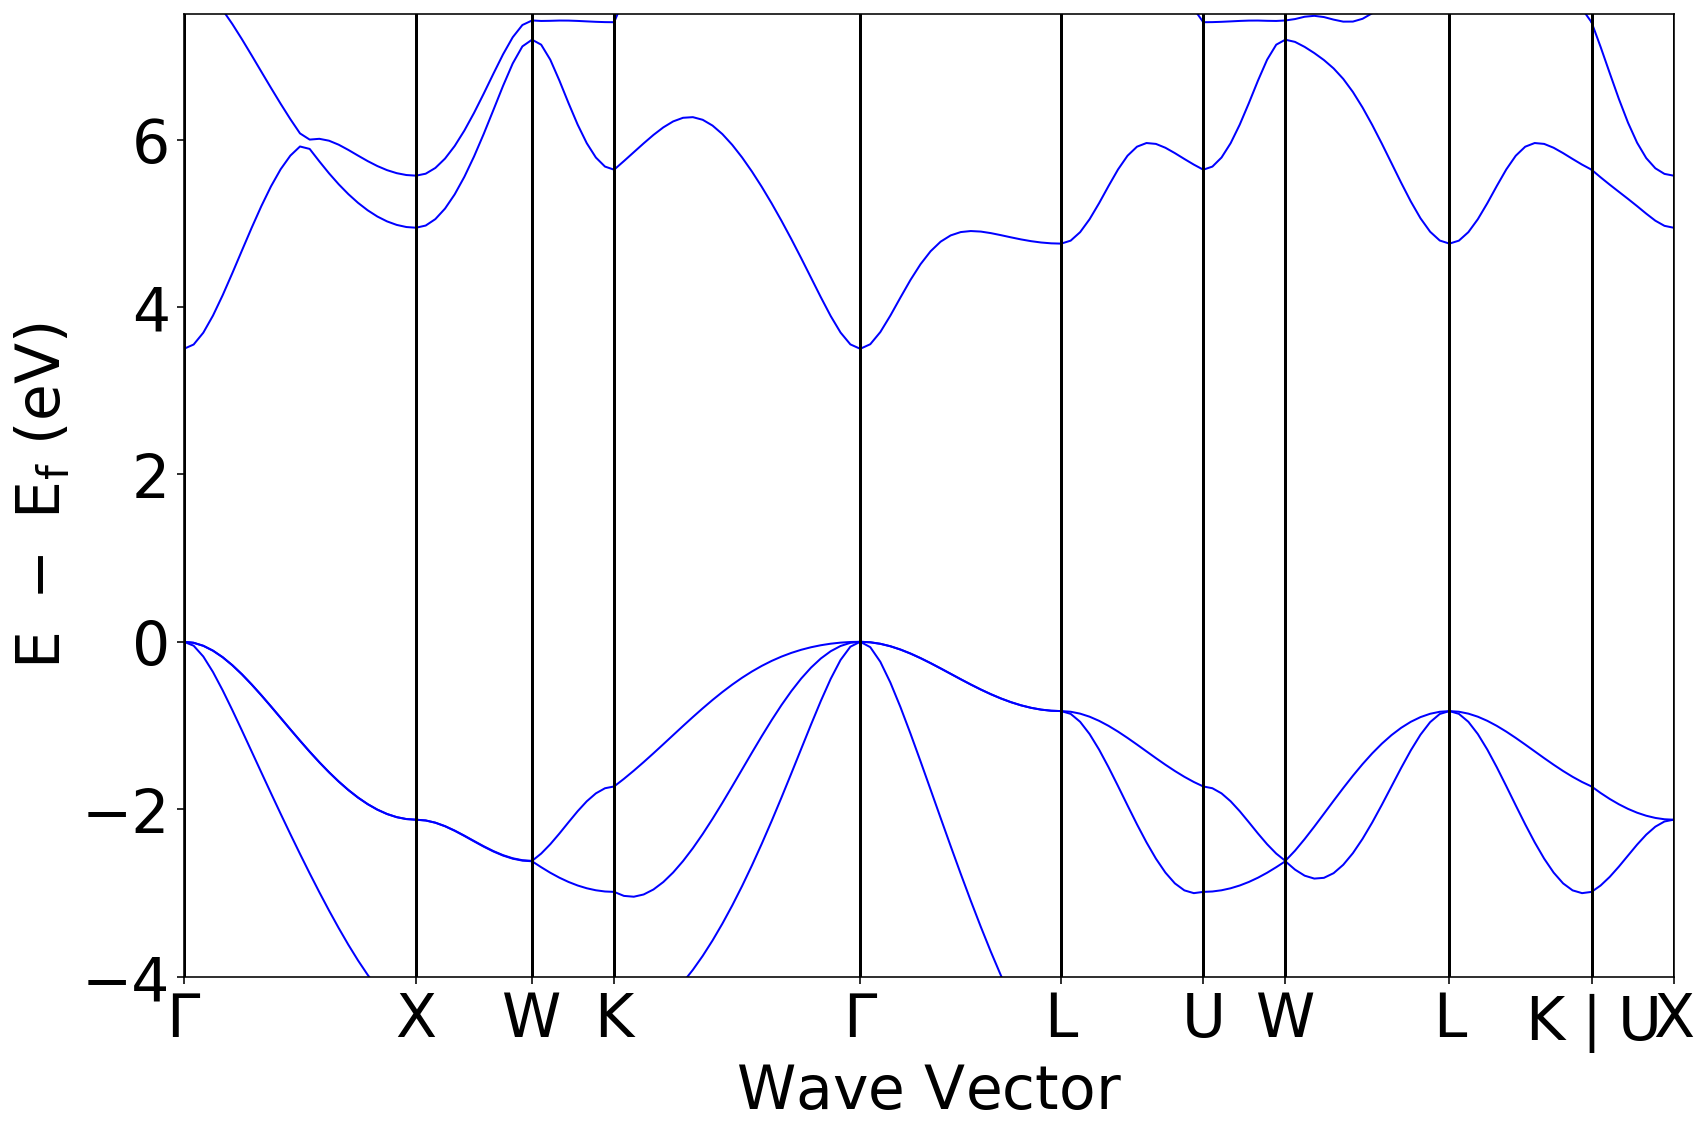

In [46]:
ZnS_bsp_scissor.show()

### 
### Get effective mass from MPContribs (teaser!)

In [18]:
# this will be installed for the workshop

!pip3 install mpcontribs-client

Defaulting to user installation because normal site-packages is not writeable


In [22]:
from mpcontribs.client import Client

In [23]:
# this is a "sacrificial" API key! Patrick will have you create your own in the next lecture

client = Client("TbtQrjVuAUe0sS3eHezh6jX9E7Ztu3MD")

In [24]:
identifier = ZnS_mpid
project = "carrier_transport"

In [25]:
ZnS_effective_mass_data = client.contributions.get_entries(
    project=project,
    identifier=identifier,
    _fields=["identifier", "formula", "data.mₑᶜᵒⁿᵈ|p.ε̄.value"]
).result()
ZnS_meff_p = ZnS_effective_mass_data['data'][0]['data']['mₑᶜᵒⁿᵈ|p']['ε̄']['value']

In [26]:
ZnS_meff_p

0.808059

###### ZnS has a really low hole effective mass!
###### ("low" is usually considered less than 1)

#
# 2. select an element to alloy with

In [27]:
from pymatgen.analysis.structure_prediction.dopant_predictor import get_dopants_from_substitution_probabilities

#### 
#### $\textit{Scientific question: Which dopants are most likely to sit at substitutional sites in my material?}$

### Machine learned rules from existing structures (coordination environment)

The 'threshold' is a probability threshold for substitution/structure predictions. Its units are descibed in Hautier et al. It just gives a ranked likeliness of substitution. I usually focus on compounds with a threshold greater than 0.01, but this depends on chemical system.

In [28]:
threshold = 0.001  # p

In [29]:
substitutional_dopants = get_dopants_from_substitution_probabilities(
    ZnS_structure, num_dopants=10, threshold=threshold)

###### Here are some options to dope ZnS p-type

In [30]:
p_dopants = substitutional_dopants['p_type']

In [31]:
pd.DataFrame(p_dopants)

,probability,dopant_species,original_species
0,0.035178,Na+,Zn2+
1,0.029318,Cu+,Zn2+
2,0.018723,N3-,S2-
3,0.016421,K+,Zn2+
4,0.015108,Li+,Zn2+
5,0.005241,Ag+,Zn2+
6,0.005069,O2-,Zn2+
7,0.002676,Au+,Zn2+
8,0.002676,Rb+,Zn2+
9,0.002676,Tl+,Zn2+


### Is a zinc-blende $A_{x}Zn_{1-x}S$ alloy possible?

###### let's see if zinc-blende binaries exist for these ternaries, and how far off the hull they sit

In [32]:
possible_cation_dopants = []
for x in p_dopants:
    specie = x["dopant_species"]
    if specie.oxi_state > 0:
        possible_cation_dopants.append(str(specie.element))

In [33]:
possible_cation_dopants

['Na', 'Cu', 'K', 'Li', 'Ag', 'Au', 'Rb', 'Tl']

###### note: get query tags here https://github.com/materialsproject/mapidoc/tree/master/materials

In [34]:
query = mpr.query({
        # input query tags
        "elements": {"$all": ["S"], "$in": possible_cation_dopants},
        "nelements": 2,
        "spacegroup.symbol": "F-43m"},

        # output query tags
        ["task_id", "e_above_hull", "pretty_formula", "icsd_ids"]
         )

In [35]:
pd.DataFrame(query)

,task_id,e_above_hull,pretty_formula,icsd_ids
0,mp-760381,0.012687,CuS,[]
1,mp-28963,0.267027,Ag8S,[]


###### Only Cu! ($Ag_8S$ is a theroetical intermetallic) CuS is a theoretical compound and is not on the hull, but it's close. Ok, so let's pick Cu$^{+}$ to use as a p-type dopant (see Woods-Robinson et al. 2019, https://doi.org/10.1016/j.matt.2019.06.019)

##### We’re not done, but this is a starting point for dopants to investigate with defect calculations !! This can be accomplished using workflows such as PyCDT (Broberg et al. 2018), which we are working on implementing via atomate.

###
### Plot some CuS properties

In [36]:
CuS_mpid = query[0]["task_id"]
print(CuS_mpid)

mp-760381


In [37]:
CuS_structure = mpr.get_structure_by_material_id(CuS_mpid)

###### 
###### Band structure

In [38]:
CuS_bs = mpr.get_bandstructure_by_material_id(CuS_mpid)

In [39]:
CuS_bs.get_band_gap()

{'energy': 0.0, 'direct': False, 'transition': None}

In [40]:
CuS_bsp = BSPlotter(CuS_bs)

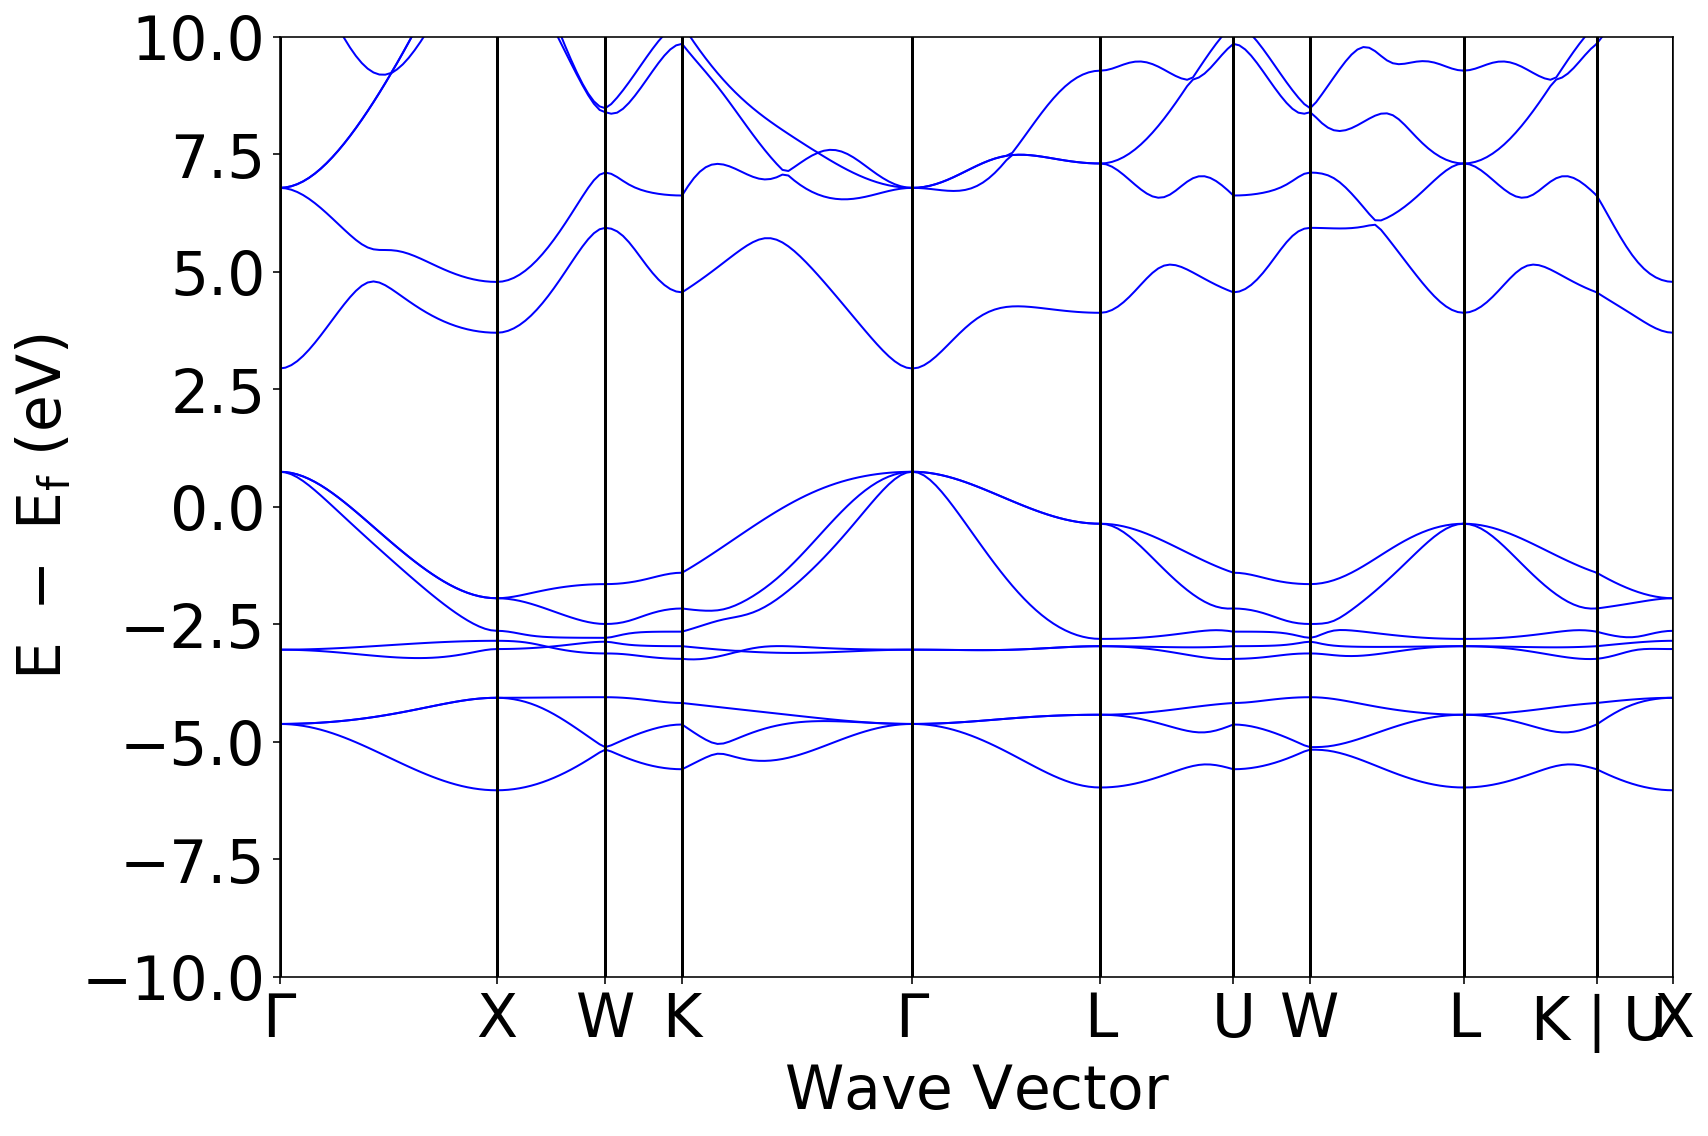

In [41]:
CuS_bsp.show()

In [101]:
key = list(CuS_bs.bands.keys())[0]
bands = CuS_bs.bands[key]
Cu_gap_ish = bands[7].min() - bands[6].max()

In [103]:
def gap(x):
    return 3.5 * (1 - x) + 0.805 * (1.5) * (x)

In [104]:
gap(1/4)

2.926875

###### 
###### Effective mass

In [60]:
CuS_effective_mass_data = client.contributions.get_entries(
    project=project,
    identifier=CuS_mpid,
    _fields=["identifier", "formula", "data.mₑᶜᵒⁿᵈ|p.ε̄.value"]
).result()
CuS_meff_p = CuS_effective_mass_data['data'][0]['data']['mₑᶜᵒⁿᵈ|p']['ε̄']['value']

In [61]:
CuS_meff_p

4.22938e-05

###### This is teeny tiny!

###
### What does the Cu-Zn-S phase diagram look like?

In [113]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, CompoundPhaseDiagram, GrandPotentialPhaseDiagram

In [63]:
entries = mpr.get_entries_in_chemsys(['Cu', 'Zn', 'S'])

In [66]:
pd = PhaseDiagram(entries)

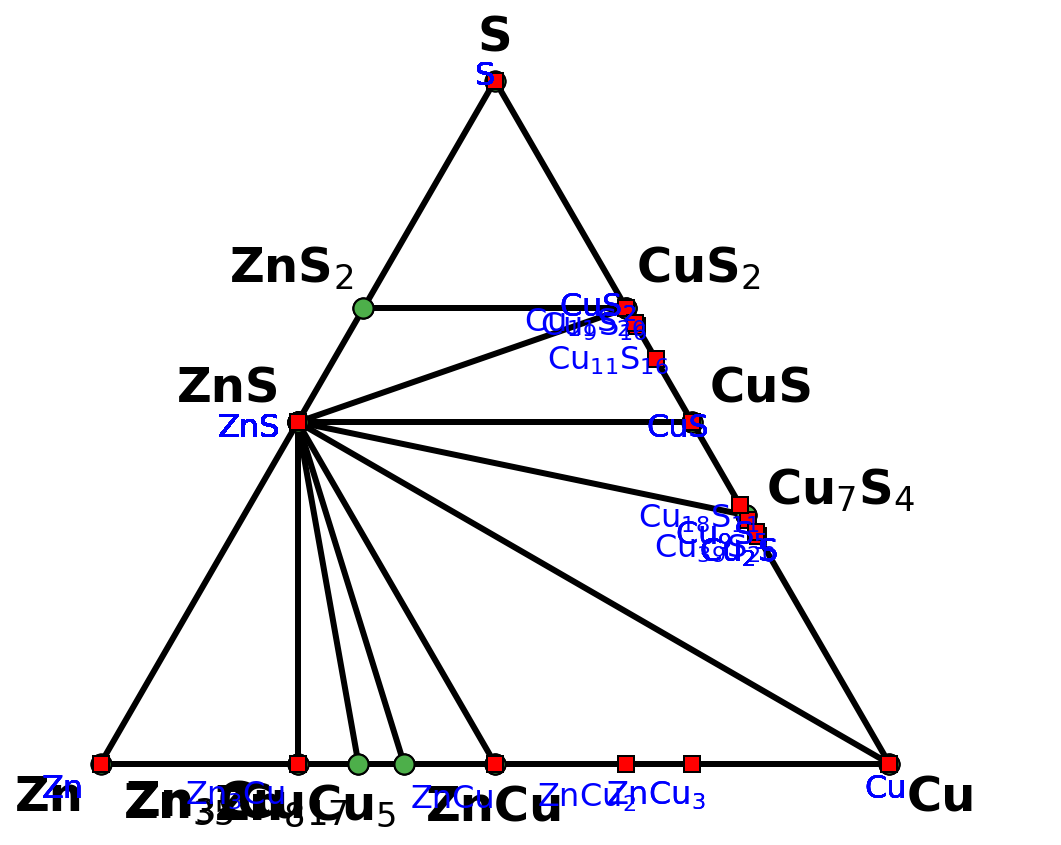

In [67]:
plotter = PDPlotter(pd, show_unstable=True)
plotter.show()

######
###### Energies referenced to elements

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

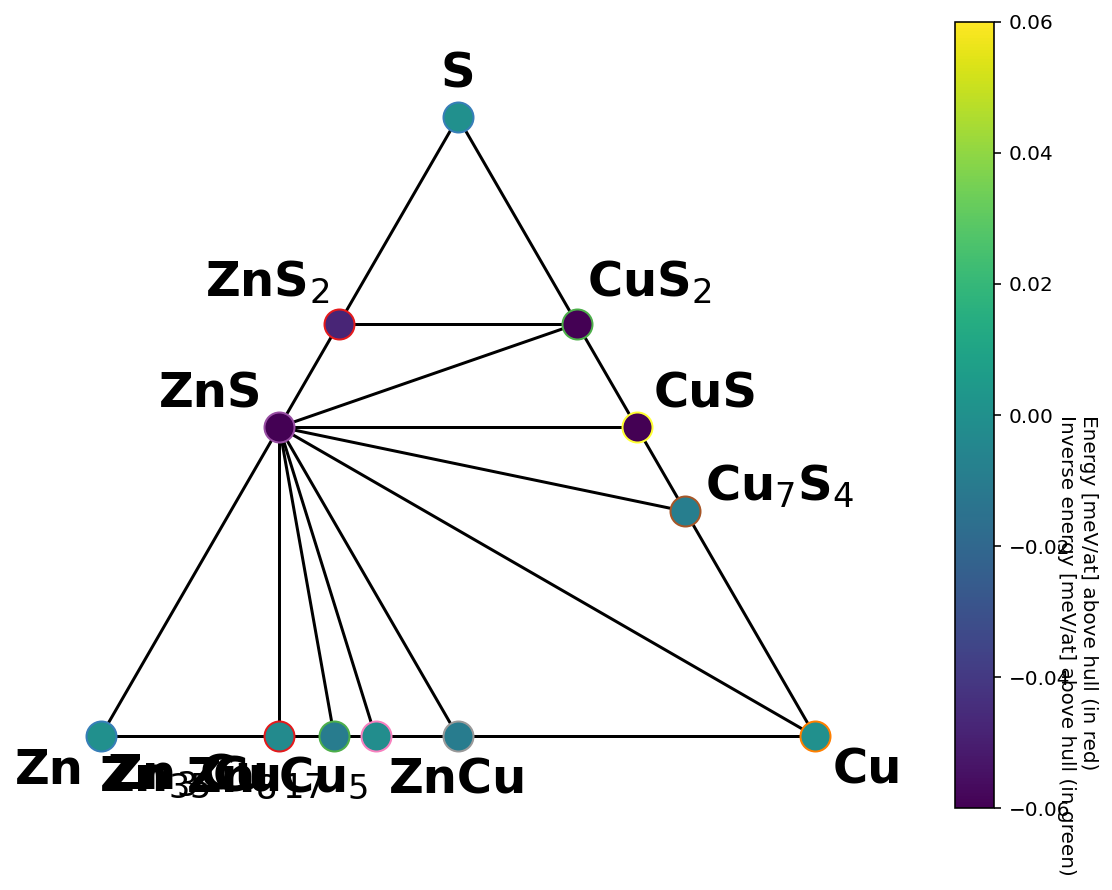

In [117]:
plotter = PDPlotter(pd, show_unstable=False)
plotter.get_plot(pd, label_unstable=False, energy_colormap='viridis')

###### 
###### Ternary space is EMPTY!! Let's fill it in

In [115]:
from pymatgen import Element

# 
# 3. transform your structure to make a new alloy

### 
### substitute your dopant to create a disordered structure

In [14]:
print(structure)

Full Formula (Zn1 S1)
Reduced Formula: ZnS
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Zn2+  0     0     0            0
  1  S2-   0.25  0.25  0.25        -0


### 
### pick an alloy fraction to substitute

We know from the literature that there is a "transparent conducting regime" in 

###### 
###### Now, so let's substitute 1/4 of the Zn$^{2+}$ with Cu$^{+}$ (note: we will be ignoring charge compensation here, but this is important to take into account in real calculations!)

In [71]:
structure = mpr.get_structure_by_material_id("mp-10695")
structure.add_oxidation_state_by_guess()

In [72]:
specie_to_replace = "Zn2+"
specie_to_substitute = "Cu+"
substitution_fraction = 0.25

In [73]:
disordered_structure = structure.copy()
disordered_structure.replace_species(
    {specie_to_replace: {specie_to_substitute: substitution_fraction,
                         specie_to_replace: 1 - substitution_fraction}}
)

In [74]:
print(disordered_structure)

Full Formula (Zn0.75 Cu0.25 S1)
Reduced Formula: Zn0.75Cu0.25S1
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP                        a     b     c    magmom
---  ---------------------  ----  ----  ----  --------
  0  Zn2+:0.750, Cu+:0.250  0     0     0            0
  1  S2-                    0.25  0.25  0.25        -0


In [76]:
# if you want to download this file

disordered_structure.to("cif", "disordered_structure.cif")

###### 
###### Screen shot of disordered structure

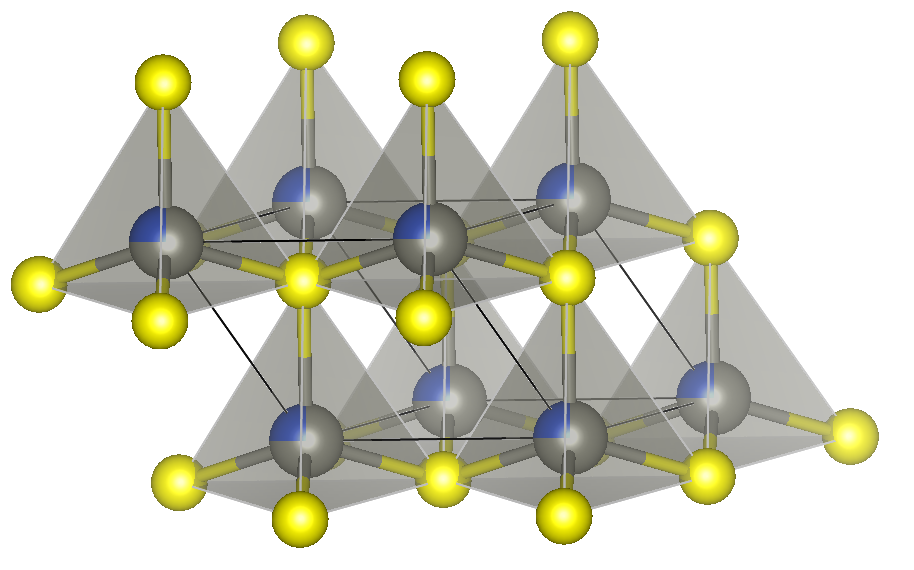

### 
### make a supercell!

Our structure is a "disordered crystal structure", where each site has partial occupancy of a Zn and Cu atom. Though disorder may indeed be more representative of a real crystal structure, we need to convert this to an ordered structure to perform DFT calculations. To do this, we create a disordered supercell and then perform a disorder-to-order transformation

In [81]:
substitution_fraction

0.25

In [82]:
disordered_supercell = disordered_structure * [2, 2, 2]

In [83]:
print(disordered_supercell)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP                         a      b      c    magmom
---  ---------------------  -----  -----  -----  --------
  0  Zn2+:0.750, Cu+:0.250  0      0      0             0
  1  Zn2+:0.750, Cu+:0.250  0      0      0.5           0
  2  Zn2+:0.750, Cu+:0.250  0      0.5    0             0
  3  Zn2+:0.750, Cu+:0.250  0      0.5    0.5           0
  4  Zn2+:0.750, Cu+:0.250  0.5    0      0             0
  5  Zn2+:0.750, Cu+:0.250  0.5    0      0.5           0
  6  Zn2+:0.750, Cu+:0.250  0.5    0.5    0             0
  7  Zn2+:0.750, Cu+:0.250  0.5    0.5    0.5           0
  8  S2-                    0.125  0.125  0.125        -0
  9  S2-                    0.125  0.125  0.625        -0
 10  S2-                    0.125  0.625  0.125        -0
 11  S2-                    0.125  0.625  0.625        -0
 12  S2-                    0.625  0.125  0.

### 
### Quick aside: intro to transformations

Pymatgen supports a variety of structural "transformations" (Oxana introduced this in her talk). A list of supported transformations is available https://pymatgen.org/pymatgen.transformations.html.

###### 
###### Here are three methods to take a disordered structure, and order it:

1. OrderDisorderStructureTransformation
2. EnumerateStructureTransformation: uses enumlib
3. SQSTransformation: uses ATAT, a code for creating special quasirandom structures (SQS)

###### 
###### For this demo, we'll be focusing on the most simple transformation: OrderDisorderStructureTransformation

###
### OrderDisorderStructureTransformation

In [84]:
from pymatgen.transformations.advanced_transformations import OrderDisorderedStructureTransformation

In [85]:
odst = OrderDisorderedStructureTransformation(no_oxi_states=False)

In [88]:
ordered_structures = odst.apply_transformation(disordered_supercell,
                                             return_ranked_list = 10)

In [89]:
ordered_structures

[{'energy': -285.4743424481398,
  'energy_above_minimum': 0.0,
  'structure': Structure Summary
  Lattice
      abc : 7.707845752595208 7.707845752595208 7.707845752595208
   angles : 60.00000000000001 60.00000000000001 60.00000000000001
   volume : 323.8053704338693
        A : 0.0 5.45027 5.45027
        B : 5.45027 0.0 5.45027
        C : 5.45027 5.45027 0.0
  PeriodicSite: Zn2+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
  PeriodicSite: Zn2+ (2.7251, 0.0000, 2.7251) [0.0000, 0.5000, 0.0000]
  PeriodicSite: Zn2+ (5.4503, 2.7251, 2.7251) [0.0000, 0.5000, 0.5000]
  PeriodicSite: Zn2+ (0.0000, 2.7251, 2.7251) [0.5000, 0.0000, 0.0000]
  PeriodicSite: Zn2+ (2.7251, 5.4503, 2.7251) [0.5000, 0.0000, 0.5000]
  PeriodicSite: Zn2+ (5.4503, 5.4503, 5.4503) [0.5000, 0.5000, 0.5000]
  PeriodicSite: Cu+ (2.7251, 2.7251, 0.0000) [0.0000, 0.0000, 0.5000]
  PeriodicSite: Cu+ (2.7251, 2.7251, 5.4503) [0.5000, 0.5000, 0.0000]
  PeriodicSite: S2- (1.3626, 1.3626, 1.3626) [0.1250, 0.1250, 0.1250]


###### 
###### This is a list of ten structures ranked by Ewald sum ("energy")
###### 
###### Let's just use the first entry for our example

In [90]:
ordered_structure = ordered_structures[0]["structure"]

In [91]:
print(ordered_structure)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


In [92]:
# if you want to download this file

ordered_structure.to("cif", "ordered_structure.cif")

(note: "-0" is actually just 0, as this is a non-magnetic configuration)

###### Now we have an alloy structure!!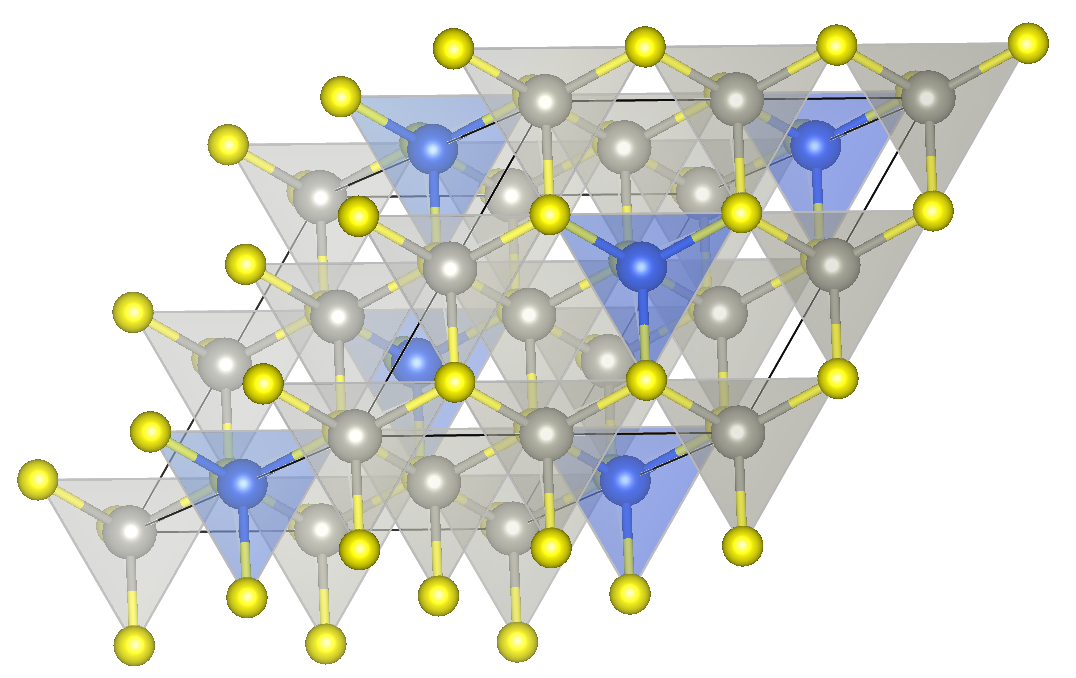

### 
### Guessing lattice parameters before DFT calculation

###### We can use Vegard's law to guess what a $Cu_{0.25}Zn_{0.75}S$ alloy's lattice parameters would look like:

In [227]:
def vegard_guess(base_structure, substituting_structure, substitution_fraction, lattice_constant="a", bowing=0):

    mapping = {"a": 0, "b": 1, "c": 2}
    if lattice_constant not in mapping:
        print("need to specify lattice constant!")
    base_lat = base_structure.lattice.abc[mapping[lattice_constant]]
    sub_lat = substituting_structure.lattice.abc[mapping[lattice_constant]]

    vegard_guess = (base_lat * (1 - substitution_fraction) + \
                   sub_lat * (substitution_fraction)) - \
                   bowing * substitution_fraction * (1 - substitution_fraction)

    return vegard_guess

In [228]:
CuZnS_vegard_guess = vegard_guess(ZnS_structure, CuS_structure, 0.25)

In [229]:
CuZnS_vegard_guess

3.8091962510672115

###### 
###### Alternatively, pymatgen has a data-mined lattice scaling (DLS) scheme that relies on data-mined bond lengths to predict the crystal volume of a given structure.
- We apply this here to create a starting point structure, which we can then fine-tune with DFT structure relaxation.
- DISCLAIMER! It's a bit janky, and is NOT a substitute for a DFT relaxation!!!

In [97]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor

In [98]:
v = DLSVolumePredictor()
ordered_structure_guess = v.get_predicted_structure(ordered_structure)

In [99]:
print(ordered_structure_guess)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.597133   7.597133   7.597133
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


In [93]:
# should I run this on VASP and then give them the result as an input to the next step?

# 
# 4. calculate new properties!

### calculate XRD, compare to original structure

now, we can compare this structure to our original structure to, for example, see how the XRD patterns shift

In [100]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [101]:
xrd = XRDCalculator(wavelength='CuKa')

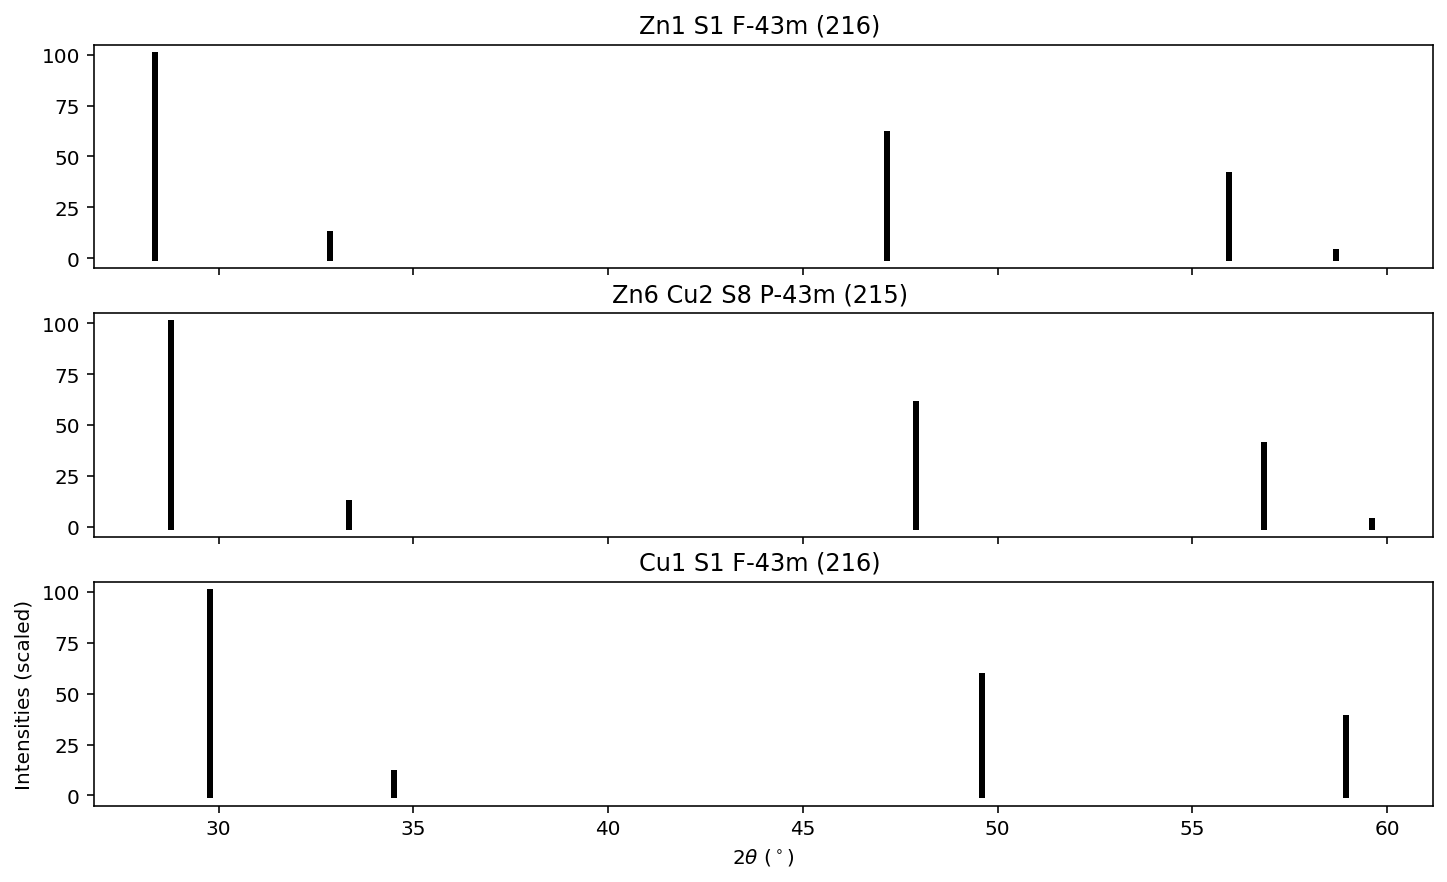

In [110]:
xrd_plots = xrd.plot_structures([ZnS_structure, ordered_structure_guess, CuS_structure], annotate_peaks=False, two_theta_range=[25,60])

you can see how the peaks shift slightly to the right with Cu integration!

###
### New phase diagram?

#
# 5. test your skills

Now, try this exercise on a structure of interest to you!

In [84]:
# TBD